# ForSys: non-invasive stress inference from time-lapse microscopy
Augusto Borges <sup>1, 2</sup>, Jerónimo  R. Miranda-Rodríguez <sup>1, 3</sup>, Alberto Sebastián Ceccarelli <sup>4</sup>, Guilherme Ventura<sup>5</sup>, Jakub Sedzinski <sup>5</sup>, Hernán López-Schier <sup>1,2,6</sup> & Osvaldo Chara <sup>7, 8, 9</sup>

1) Unit Sensory Biology, Helmholtz Zentrum München, Munich, Germany
2) Graduate School of Quantitative Biosciences (QBM), Munich, Germany
3) Instituto de Neurobiología, Universidad Nacional Autónoma de México (UNAM), Boulevard Juriquilla 3001, Juriquilla, México
4) Systems Biology Group (SysBio), Institute of Physics of Liquids and Biological Systems (IFLySIB), National Scientific and Technical Research Council (CONICET), University of La Plata, La Plata, Argentina
5) The Novo Nordisk Foundation Center for Stem Cell Medicine (reNEW), University of Copenhagen, Blegdamsvej 3B, 2200, Copenhagen, Denmark
6) Division of Science, New York University Abu Dhabi, Saadiyat Island, United Arab Emirates
7) School of Biosciences, University of Nottingham, Sutton Bonington Campus, Nottingham, LE12 5RD, UK
8) Instituto de Tecnología, Universidad Argentina de la Empresa, Buenos Aires, Argentina
9) Corresponding author: osvaldo.chara@nottingham.ac.uk

### Generate an inference in a set of SurfaceEvolver steps

In [1]:
import sys
sys.path.append('..')
import forsys as fs
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_FOLDER = os.path.join("data", "in_silico")
RESULTS_FOLDER = os.path.join("results")

max_time = 25

# This is only necessary if you wish to create outputs
# if not os.path.exists(RESULTS_FOLDER):
#     os.makedirs(RESULTS_FOLDER)

#### Create all the frames by iterating in time.
The real_time is used to get the $\Delta t$ in the velocity calculation

In [3]:
frames = {}
for time in range(max_time):
    if time == 0:
        real_time = 0
    elif time == 1:
        real_time += 1 * 25000 * 0.005
    else:
        real_time += 1 * 50 * 0.005

    lattice = fs.surface_evolver.SurfaceEvolver(os.path.join(DATA_FOLDER,
                                                             f"step_{time}.dmp"))
    frames[time] = fs.frames.Frame(time,
                                   lattice.vertices,
                                   lattice.edges,
                                   lattice.cells,
                                   time=real_time,
                                   gt=True)

##### Now create the ForSys object from all the frames. The mesh is created by automatically tracking the vertices through time

In [4]:
forsys = fs.ForSys(frames)

#### Build and solve the system of equations for the force and pressure
You could solve only the time of interest or all the times with a loop. The b_matrix parameter turns the Dynamic instance on

In [5]:
all_velocities = forsys.get_system_velocity_per_frame()
ave_velocity_to_normalize = np.mean(all_velocities)
for time in range(max_time):
    forsys.build_force_matrix(when=time)
    forsys.solve_stress(when=time,
                        b_matrix="velocity",
                        velocity_normalization=0.07 / ave_velocity_to_normalize,
                        adimensional_velocity=False,
                        method="nnls",
                        use_std=False,
                        allow_negatives=False)
    forsys.build_pressure_matrix(when=time)
    forsys.solve_pressure(when=time, method="lagrange_pressure")

/home/augusto/doctorado/forsys/forsys_prs/forsys/examples/../forsys/fmatrix.py:317: UserWarning: Numerically solving due to the following error: Singular matrix
  warnings.warn(f"Numerically solving due to the following error: {e}")


#### Create system's plots

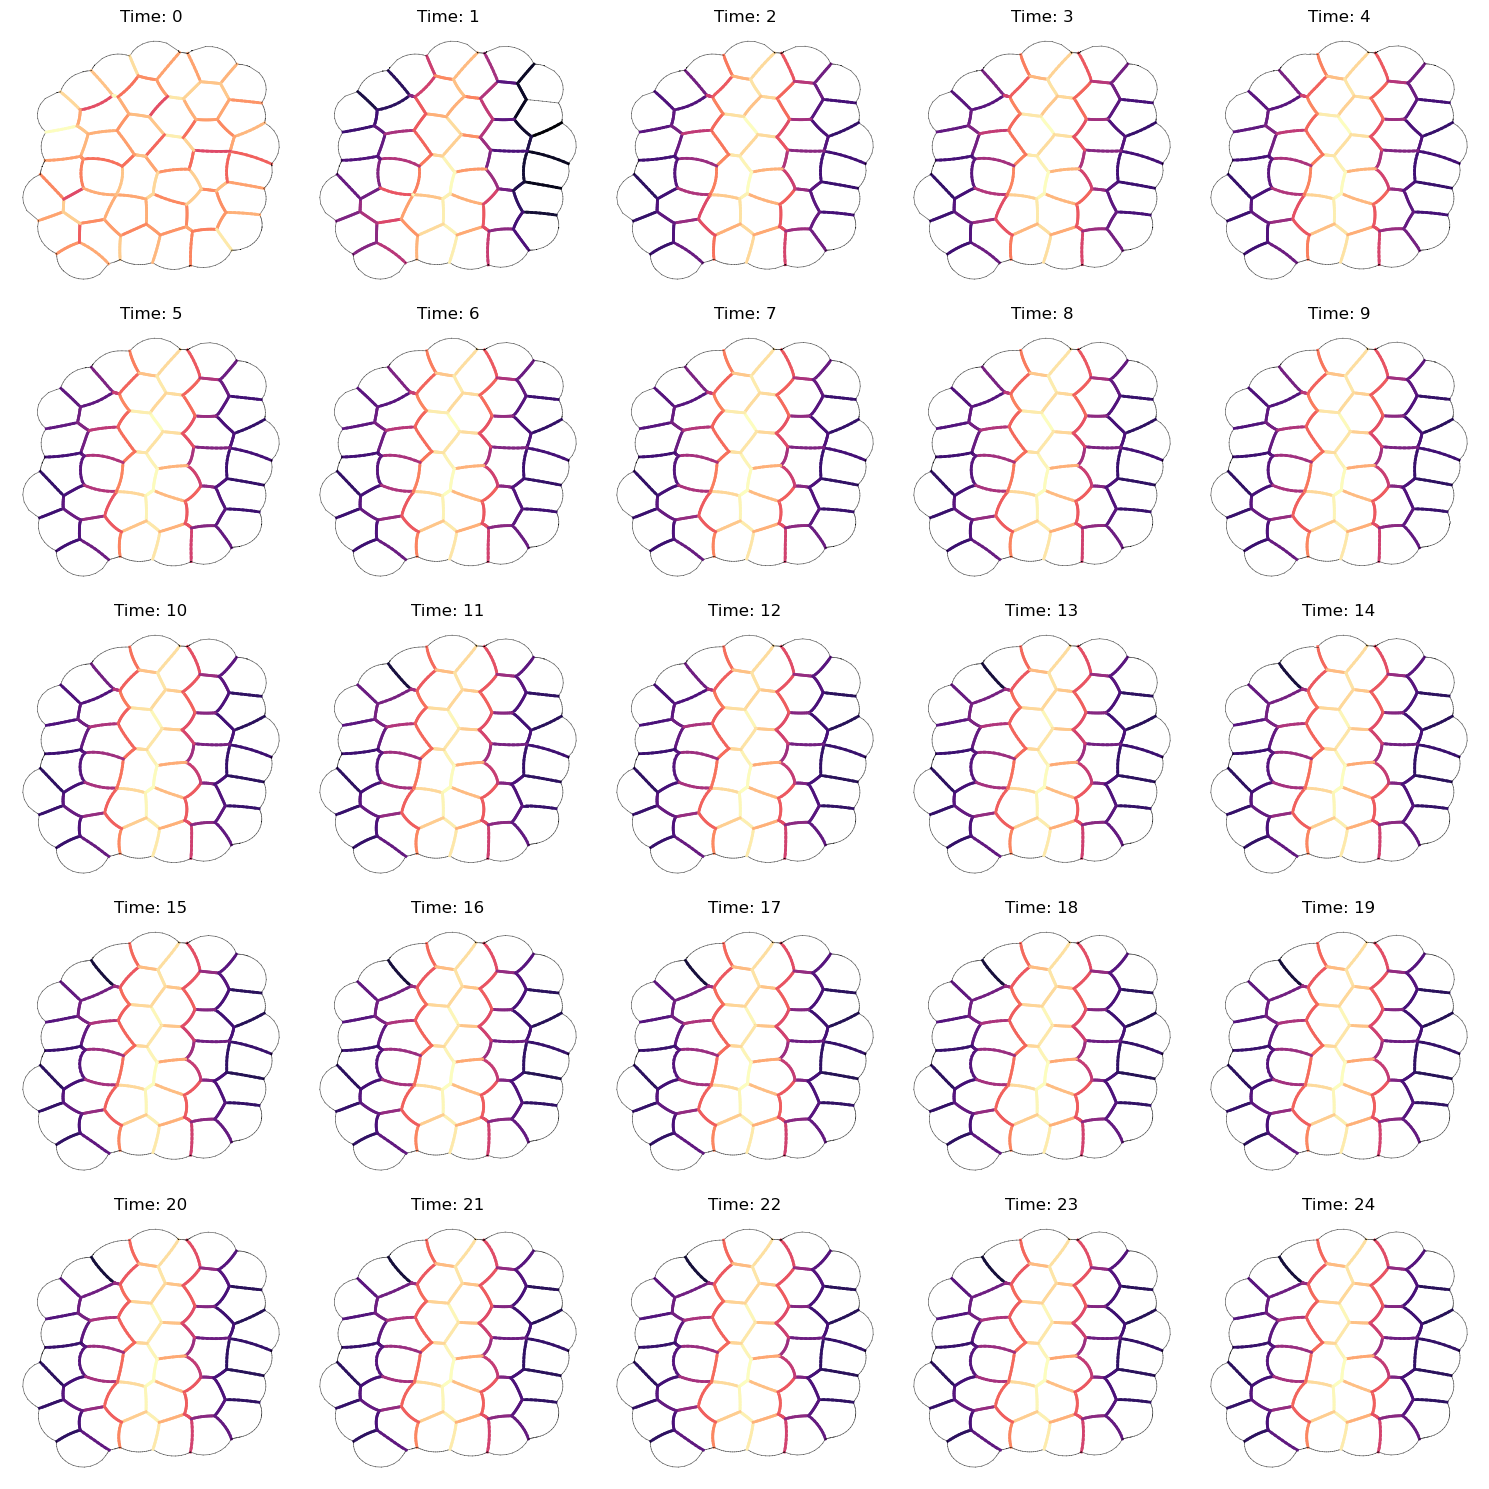

In [6]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for time, current_ax in enumerate(axs.reshape(-1)):
    _, ax = fs.plot.plot_inference(forsys.frames[time],
                                    normalized="max",
                                    mirror_y=False,
                                    colorbar=False,
                                    pressure=False,
                                    ax=current_ax)
    current_ax = ax
    current_ax.set_title(f"Time: {time}")
    current_ax.axis("off")


plt.tight_layout()
plt.show()

##### The pressure can be plotted using the pressure argument

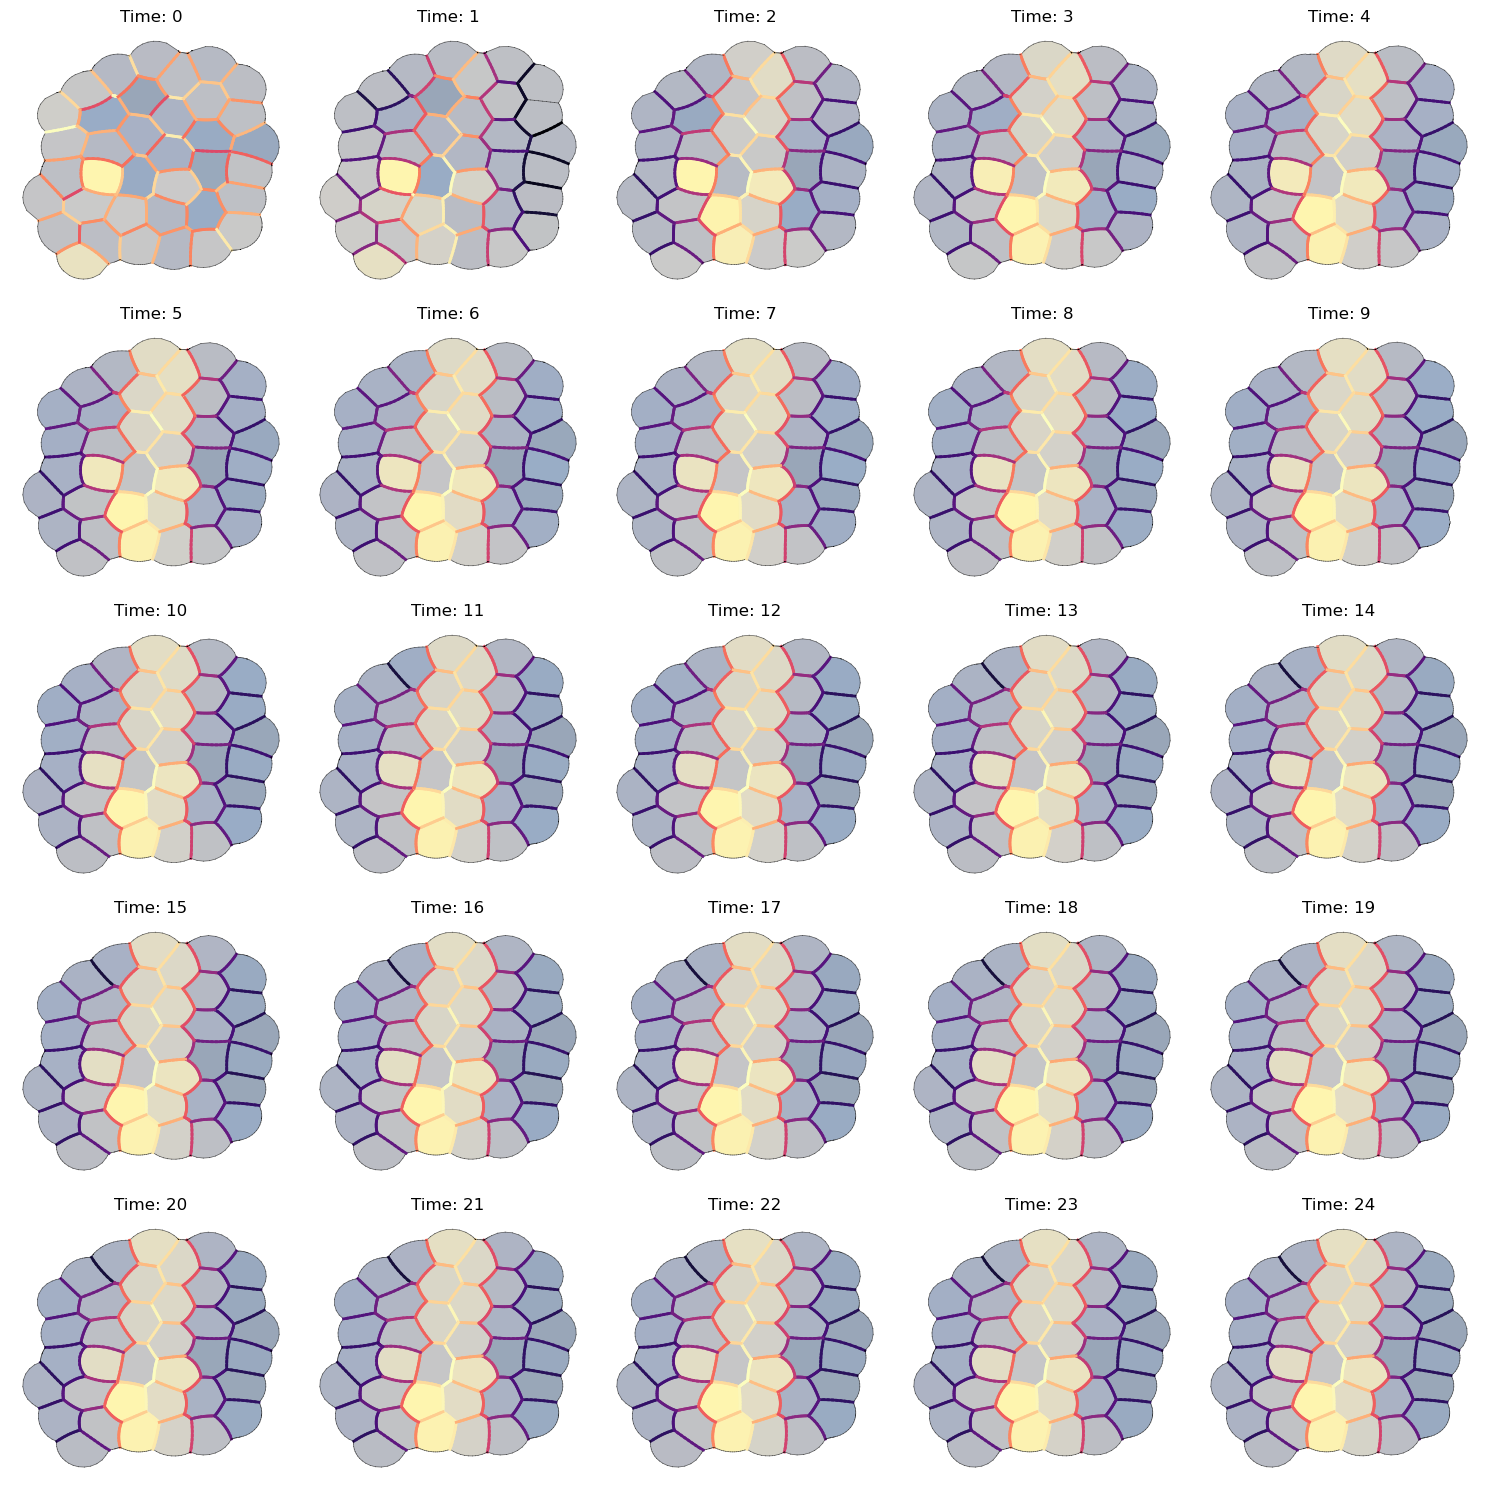

In [7]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for time, current_ax in enumerate(axs.reshape(-1)):
    _, ax = fs.plot.plot_inference(forsys.frames[time],
                                    normalized="max",
                                    mirror_y=False,
                                    colorbar=False,
                                    pressure=True,
                                    ax=current_ax)
    current_ax = ax
    current_ax.set_title(f"Time: {time}")
    current_ax.axis("off")


plt.tight_layout()
plt.show()